In [1]:
%matplotlib notebook 

import random,threading,os,sys,asyncio
from time import sleep
import pandas as pd
import numpy as np
import ipympl
from ipywidgets import interactive
import matplotlib.pyplot as plt
from threading import Thread

sys.path.append(r"C:\projects\OpenVisus\build\RelWithDebInfo")
from OpenVisus import *

Starting OpenVisus C:\Python38\lib\site-packages\OpenVisus\__init__.py 3.8.0 (tags/v3.8.0:fa919fd, Oct 14 2019, 19:37:50) [MSC v.1916 64 bit (AMD64)] sys.version_info(major=3, minor=8, micro=0, releaselevel='final', serial=0) ...


In [2]:
db=LoadDataset('http://atlantis.sci.utah.edu/mod_visus?dataset=2kbit1')
logic_box=db.getLogicBox()
dims=[logic_box[1][I]-logic_box[0][I] for I in range(3)]

def ReadSlice(db,axis,offset,quality):
    if axis==0:
        data=db.read(x=[offset,offset+1], quality=quality)
        return data[:,:,0]
    elif axis==1:
        data=db.read(y=[offset,offset+1], quality=quality)
        return data[:,0,:]
    else:
        data=db.read(z=[offset,offset+1], quality=quality)
        return data[0,:,:]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
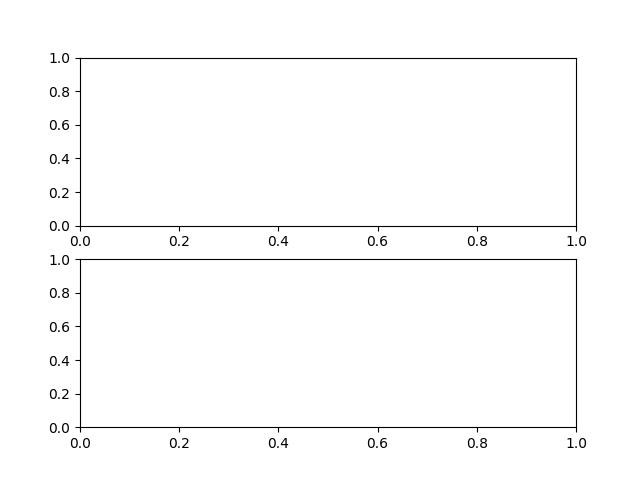

In [3]:
class ShowStatistics(Thread):
    
    # constructor
    def __init__(self,db,axis,quality):
        Thread.__init__(self)
        
        self.db=db
        self.axis=axis
        self.quality=quality
        self.repaint=True
        self.data=None
        self.logic_box=self.db.getLogicBox()
        self.dims=[self.logic_box[1][I]-self.logic_box[0][I] for I in range(3)]         
    
        # statistics
        self.x=range(self.dims[self.axis])
        self.y=[0]*self.dims[self.axis]  

        self.fig, self.axs = plt.subplots(2)
        self.start()
        # self.run()
        plt.show()

        
    # run
    def run(self):
        for offset in range(self.dims[self.axis]):
            
            sleep(0.05) # to tune!
            
            try:
                self.data=ReadSlice(self.db,self.axis,offset,self.quality)
            except:
                pass

            # count non zero pixels
            self.y[offset]=np.count_nonzero((self.data>80)*255)            
            
            #self.y=np.random.uniform(low=0, high=4000,size=len(self.x,))
            self.axs[0].cla() 
            self.axs[1].cla()
            self.axs[0].plot(self.x,self.y,color="blue")
            self.axs[1].imshow(self.data, origin='lower',cmap='gray') 
            plt.draw()
        


s=ShowStatistics(db,axis=0,quality=-15)

In [4]:
"""
class Job(Thread):
    
    # constructor
    def __init__(self):
        Thread.__init__(self)
        self.fig, self.ax = plt.subplots(2)
        self.output=[]
        self.start()
        plt.show()
        
    # run
    def run(self):
        for i in range(10):
            self.output.append(np.random.rand())
            self.ax[0].cla()
            self.ax[0].plot(self.output)
            self.ax[1].cla()
            self.ax[1].plot(self.output)
            plt.draw()
            sleep(0.3)

job = Job()
"""

'\nclass Job(Thread):\n    \n    # constructor\n    def __init__(self):\n        Thread.__init__(self)\n        self.fig, self.ax = plt.subplots(2)\n        self.output=[]\n        self.start()\n        plt.show()\n        \n    # run\n    def run(self):\n        for i in range(10):\n            self.output.append(np.random.rand())\n            self.ax[0].cla()\n            self.ax[0].plot(self.output)\n            self.ax[1].cla()\n            self.ax[1].plot(self.output)\n            plt.draw()\n            sleep(0.3)\n\njob = Job()\n'